In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
sns.set_style('darkgrid')

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from unbalanced_dataset import UnderSampler, OverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# from bokeh.plotting import figure,show,output_notebook
# from bokeh.models import Range1d
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import StratifiedKFold
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
# output_notebook()

%matplotlib inline

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')
df.columns = ['sample','clump_thickness','uni_cell_size','uni_cell_shape','marginal_adh','s_epi_cell_size','bare_nuclei','bland_chromatin','normal_nuclei','mitosis','class']
df.head()

,sample,clump_thickness,uni_cell_size,uni_cell_shape,marginal_adh,s_epi_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitosis,class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [3]:
# df['class'][df['class']==2].count()
df['class'].value_counts(2) #slight imbalance here 65% of the data is benign as opposed to about 35% malignant.

2    0.654728
4    0.345272
dtype: float64

/Users/raymondma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/raymondma/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


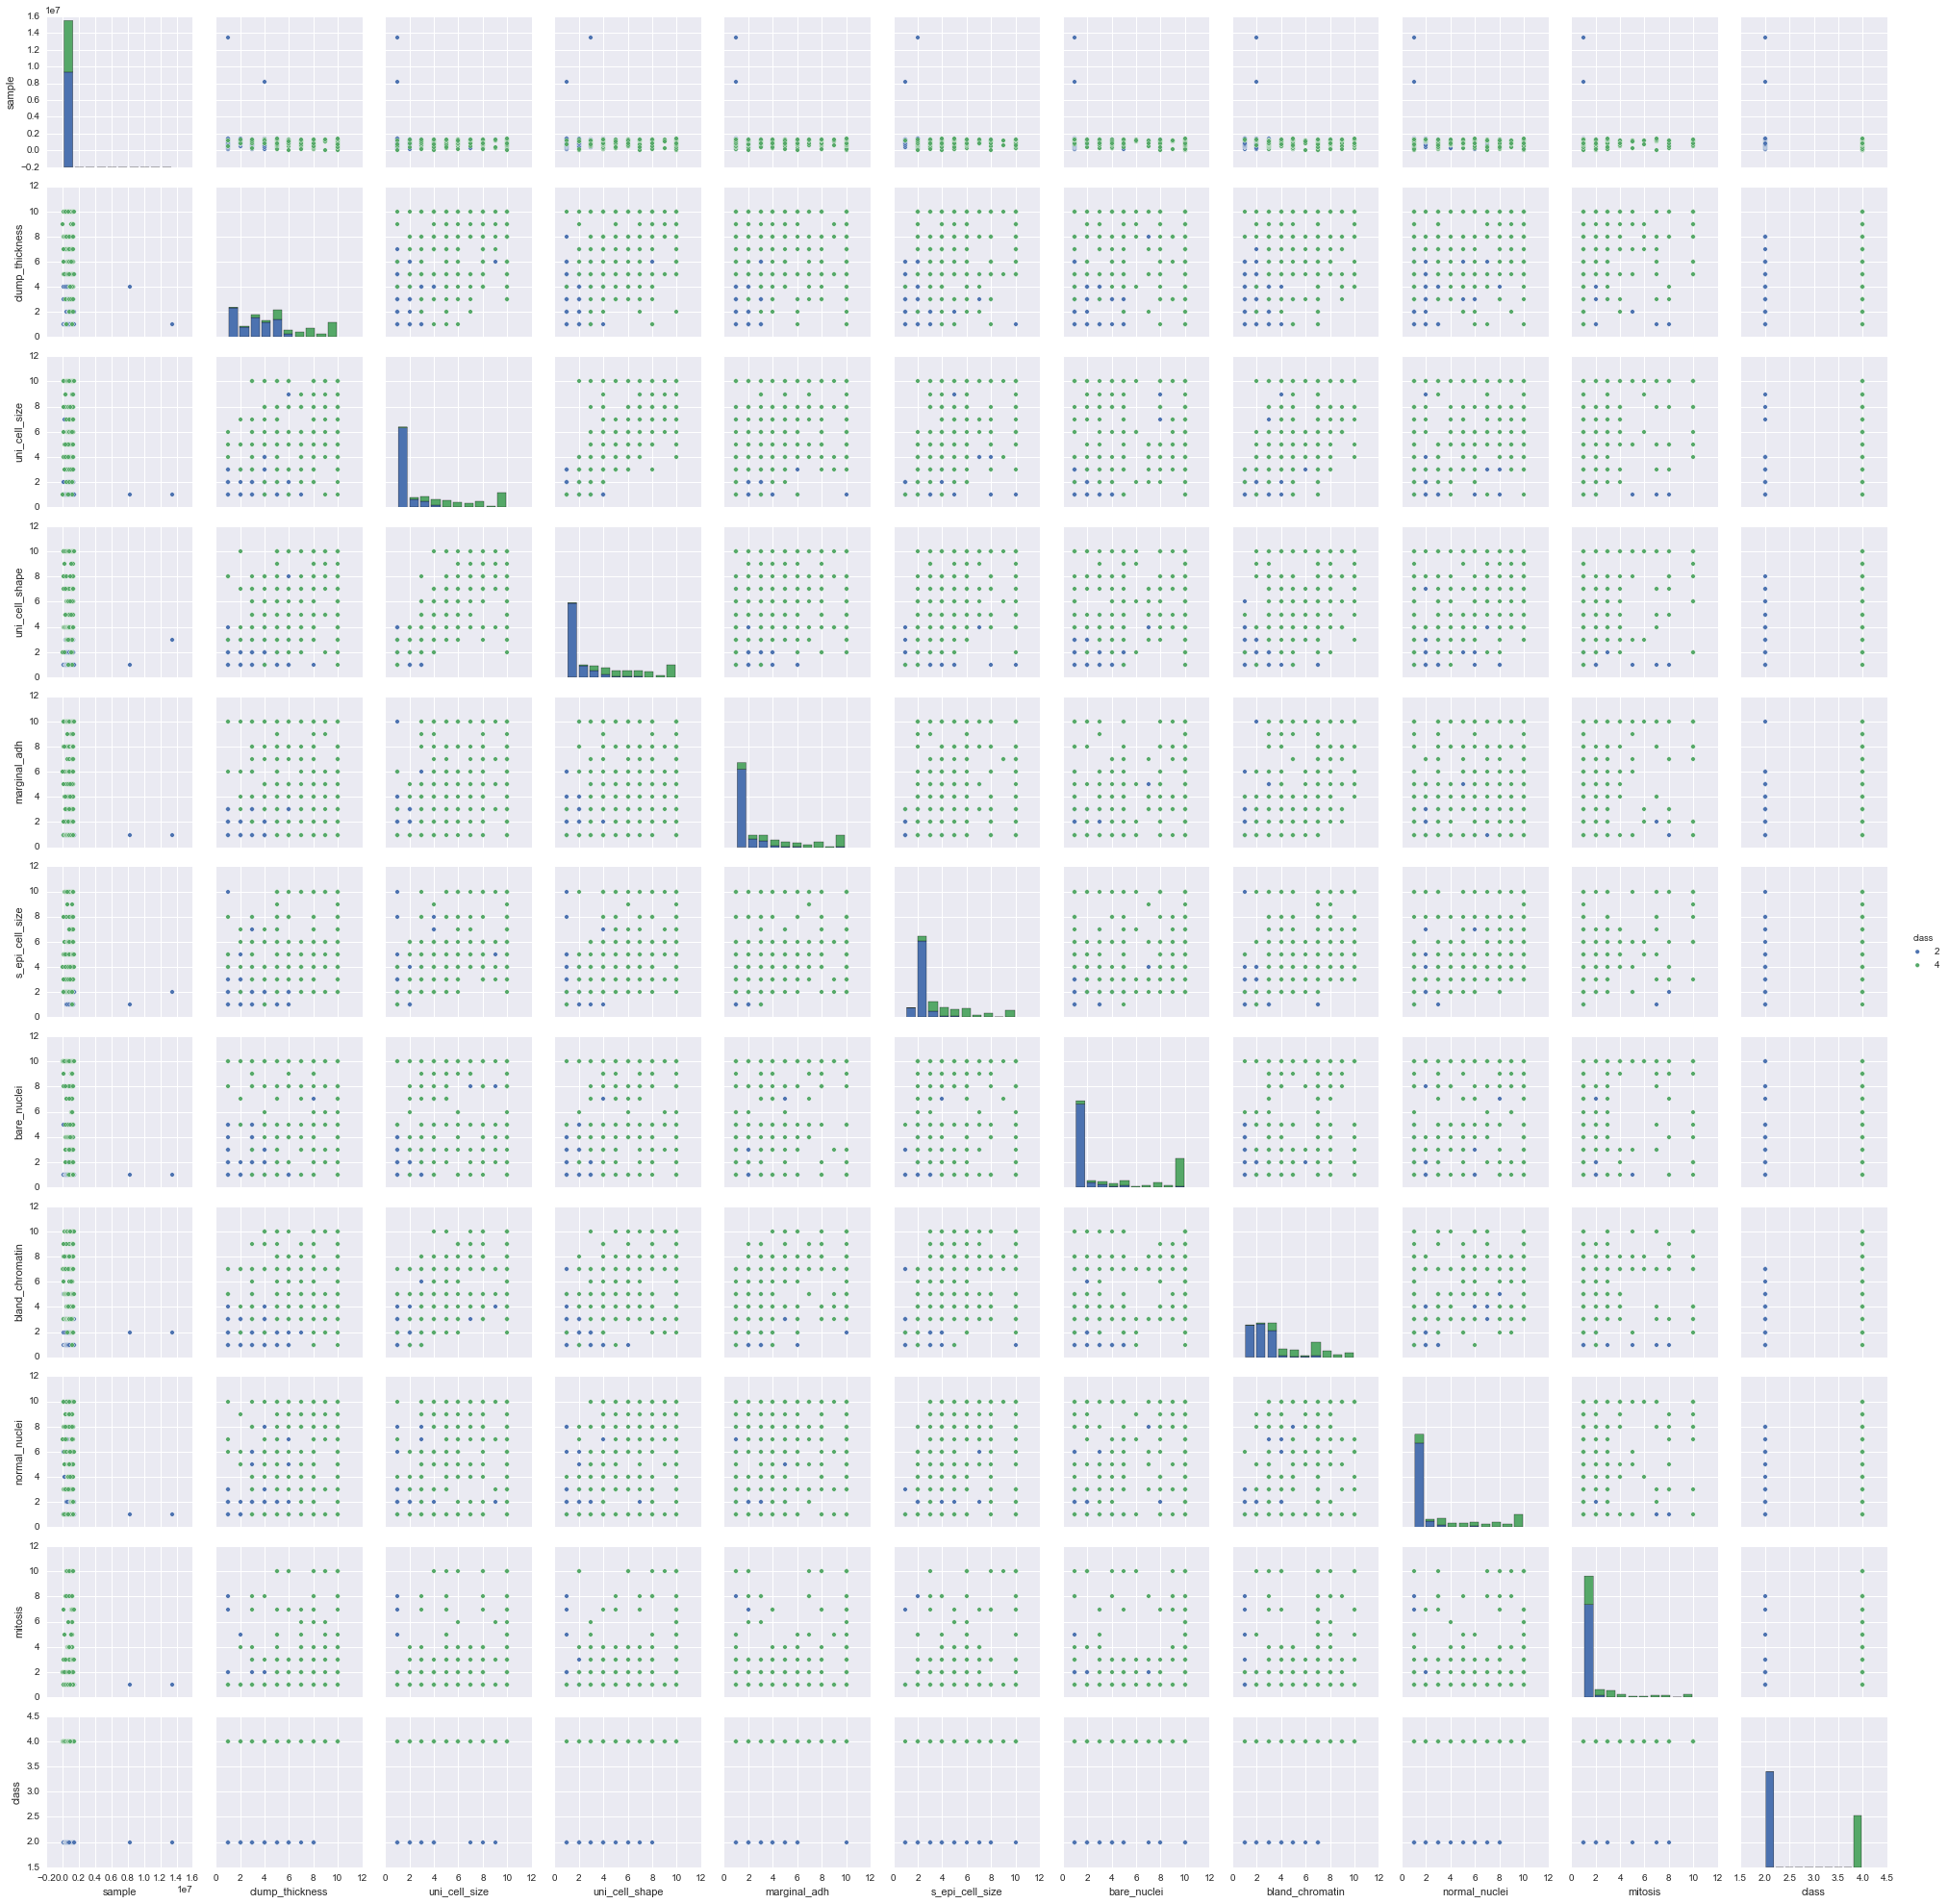

In [4]:
to_plot = df[df['bare_nuclei'] != '?']
to_plot['bare_nuclei'] = to_plot['bare_nuclei'].astype(int)
sns.pairplot(to_plot, hue="class")

In [5]:
df.bare_nuclei.replace('?', df.bare_nuclei.mode()[0], inplace=True)
df.bare_nuclei = df.bare_nuclei.astype(int)
# df.bare_nuclei.mode()[0]

In [6]:
#impute missing normal_nuclei values with either 1 nuclei or 10 nuclei
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698 entries, 0 to 697
Data columns (total 11 columns):
sample             698 non-null int64
clump_thickness    698 non-null int64
uni_cell_size      698 non-null int64
uni_cell_shape     698 non-null int64
marginal_adh       698 non-null int64
s_epi_cell_size    698 non-null int64
bare_nuclei        698 non-null int64
bland_chromatin    698 non-null int64
normal_nuclei      698 non-null int64
mitosis            698 non-null int64
class              698 non-null int64
dtypes: int64(11)
memory usage: 65.4 KB


In [7]:
# SMOTE to account for class imbalance
verbose = True
ratio = 0.75

X= df.drop('class',axis=1).values
y = df['class'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

OS = SMOTE(ratio=ratio, verbose=verbose)
osx, osy = OS.fit_transform(X_train, Y_train)

Determining classes statistics... 2 classes detected: {2: 355, 4: 203}
Finding the 5 nearest neighbours...done!
Creating synthetic samples...Generated 152 new samples ...
done!


In [10]:
columns = ['sample','clump_thickness','uni_cell_size','uni_cell_shape','marginal_adh','s_epi_cell_size','bare_nuclei','bland_chromatin','normal_nuclei','mitosis']

os_df = pd.DataFrame(osx)
os_df.columns = columns
os_df['class'] = osy
os_df.describe().T


,count,mean,std,min,25%,50%,75%,max
sample,710,1069374.236018,614493.764018,61634,859210.5,1173225.500000,1233971.750000,13454352
clump_thickness,710,5.048918,2.920669,1,3.0,5.000000,7.632484,10
uni_cell_size,710,4.001911,3.297284,1,1.0,3.000000,7.000000,10
uni_cell_shape,710,4.020068,3.156052,1,1.0,3.000000,6.775638,10
marginal_adh,710,3.391073,3.009869,1,1.0,2.000000,5.000000,10
s_epi_cell_size,710,3.666007,2.306904,1,2.0,3.000000,5.000000,10
bare_nuclei,710,4.406378,3.819791,1,1.0,2.084998,9.053025,10
bland_chromatin,710,3.916875,2.508529,1,2.0,3.000000,6.000000,10
normal_nuclei,710,3.597131,3.244843,1,1.0,1.553943,6.000000,10
mitosis,710,1.853980,1.928252,1,1.0,1.000000,1.771132,10


In [11]:
os_df.head()

,sample,clump_thickness,uni_cell_size,uni_cell_shape,marginal_adh,s_epi_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitosis,class
0,1268952,10,10,7,8,7,1,10,10,3,4
1,1171710,1,1,1,1,2,1,2,3,1,2
2,1050670,10,7,7,6,4,10,4,1,2,4
3,734111,1,1,1,3,2,3,1,1,1,2
4,95719,6,10,10,10,8,10,7,10,7,4


In [12]:
# normalize data
columns = ['sample','clump_thickness','uni_cell_size','uni_cell_shape','marginal_adh','s_epi_cell_size','bare_nuclei','bland_chromatin','normal_nuclei','mitosis','class']

os_df['class'] = os_df['class'].map({4:1, 2:0})
standard_scaler = StandardScaler()
df_norm = pd.DataFrame(standard_scaler.fit_transform(os_df))
df_norm.columns = columns
df_norm.drop('sample',inplace=True,axis=1)
df_norm.head()

,clump_thickness,uni_cell_size,uni_cell_shape,marginal_adh,s_epi_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitosis,class
0,1.696383,1.820382,0.944862,1.532351,1.446243,-0.892399,2.426687,1.974636,0.59475,1
1,-1.387275,-0.911061,-0.957588,-0.794971,-0.722692,-0.892399,-0.764682,-0.184154,-0.44319,-1
2,1.696383,0.909901,0.944862,0.867402,0.144882,1.465411,0.033160,-0.800952,0.07578,1
3,-1.387275,-0.911061,-0.957588,-0.130022,-0.722692,-0.368441,-1.163603,-0.800952,-0.44319,-1
4,0.325868,1.820382,1.896086,2.197300,1.880030,1.465411,1.229924,1.974636,2.67063,1


## Linear SVM

In [13]:
X = df_norm.drop('class',axis=1)
y = df_norm['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model = SVC(C=1,kernel='linear',probability=True).fit(X_train,Y_train)
print classification_report(Y_test,model.predict(X_test))
print "cross val score: {}".format(cross_val_score(model, X, y, cv=5).mean())

# X = df_norm.drop('class',axis=1)
# y = df_norm['class']


# parameters = {'C':[0.1, 1, 10, 100]}
# svr = SVC(kernel='linear',probability=True)
# model = grid_search.GridSearchCV(svr, parameters, n_jobs=4)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# model.fit(X_train, y_train)
# print "cross val score: {}".format(cross_val_score(model, X, y, cv=5).mean())
# print model.best_params_


             precision    recall  f1-score   support

       -1.0       1.00      0.94      0.97        71
        1.0       0.95      1.00      0.97        71

avg / total       0.97      0.97      0.97       142

cross val score: 0.969014084507


In [ ]:
#Display the confusion matrix, and AUC.

print confusion_matrix(Y_test,model.predict(X_test))

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    
    p = figure(title='Receiver Operating Characteristic')
    # Plot ROC curve
    p.line(x=fpr,y=tpr,legend='ROC curve (area = %0.3f)' % roc_auc)
    p.x_range=Range1d(0,1)
    p.y_range=Range1d(0,1)
    p.xaxis.axis_label='False Positive Rate or (1 - Specifity)'
    p.yaxis.axis_label='True Positive Rate or (Sensitivity)'
    p.legend.orientation = "bottom_right"
    show(p)

target_predicted_proba = model.predict_proba(X_test)
# plot_roc_curve(Y_test, target_predicted_proba)

target_predicted_proba = model.predict_proba(X_test)
plot_roc_curve(Y_test, target_predicted_proba)

In [ ]:
#learning curve
train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X,
                                                        y,
                                                        train_sizes=np.linspace(0.05, 1.0, 10),
                                                        cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=0))

## learning curve indicates that we have enough data

In [ ]:
# Create our base figure
p = figure(title='Learning Curve',y_range=(0,1))
p.line(x=train_sizes,y=train_scores.mean(axis=1),color='red',legend="Training Scores")
p.line(x=train_sizes,y=test_scores.mean(axis=1),color='blue',legend = "Test Scores")
p.legend.orientation = "bottom_right"
show(p)

## Decision Tree


In [14]:
treeclf = DecisionTreeClassifier(max_depth=20)
treeclf.fit(X_train,Y_train)
print classification_report(Y_test,treeclf.predict(X_test))
print "cross val score: {}".format(cross_val_score(treeclf, X, y, cv=5).mean())

             precision    recall  f1-score   support

       -1.0       0.94      0.92      0.93        71
        1.0       0.92      0.94      0.93        71

avg / total       0.93      0.93      0.93       142

cross val score: 0.945070422535


In [ ]:

target_predicted_proba = treeclf.predict_proba(X_test)
plot_roc_curve(Y_test, target_predicted_proba)

In [ ]:
#learning curve
train_sizes, train_scores, test_scores = learning_curve(treeclf,
                                                        X,
                                                        y,
                                                        train_sizes=np.linspace(0.05, 1.0, 10),
                                                        cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=0))

p = figure(title='Learning Curve',y_range=(0,1))
p.line(x=train_sizes,y=train_scores.mean(axis=1),color='red',legend="Training Scores")
p.line(x=train_sizes,y=test_scores.mean(axis=1),color='blue',legend = "Test Scores")
p.legend.orientation = "bottom_right"
show(p)

## Random Forest

In [15]:
# grid search to find hyperparams
PARAMETERS = {'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 'max_features':[2,4,6,8,9], 
              'n_estimators':[10,20,50,100], 'min_samples_leaf':[2,4]}
SCORING = 'f1'

model = RandomForestClassifier()

In [16]:
clf = grid_search.GridSearchCV(model, PARAMETERS, scoring=SCORING, verbose=True, n_jobs=4)
clf.fit(X,y)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=4)]: Done 212 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 1112 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed:   43.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_features': [2, 4, 6, 8, 9], 'n_estimators': [10, 20, 50, 100], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'min_samples_leaf': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=True)

In [17]:
print clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=2, max_leaf_nodes=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [18]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=2, max_leaf_nodes=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train, Y_train)  
preds = clf.predict(X_test)
print classification_report(Y_test,clf.predict(X_test))
print "cross val score: {}".format(cross_val_score(clf, X, y, cv=5).mean())

             precision    recall  f1-score   support

       -1.0       1.00      0.97      0.99        71
        1.0       0.97      1.00      0.99        71

avg / total       0.99      0.99      0.99       142

cross val score: 0.967605633803


In [ ]:
target_predicted_proba = clf.predict_proba(X_test)
plot_roc_curve(Y_test, target_predicted_proba)

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(clf,
                                                        X,
                                                        y,
                                                        train_sizes=np.linspace(0.05, 1.0, 10),
                                                        cv = StratifiedKFold(y, n_folds=5, shuffle=True))

p = figure(title='Learning Curve',y_range=(0,1))
p.line(x=train_sizes,y=train_scores.mean(axis=1),color='red',legend="Training Scores")
p.line(x=train_sizes,y=test_scores.mean(axis=1),color='blue',legend = "Test Scores")
p.legend.orientation = "bottom_right"
show(p)

## SVM + DT Ensemble

In [19]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[('svm', model), ('dt', treeclf)], voting='soft')
eclf1 = eclf1.fit(X, y)  
print classification_report(Y_test,eclf1.predict(X_test))
print "cross val score: {}".format(cross_val_score(eclf1, X, y, cv=5).mean())

             precision    recall  f1-score   support

       -1.0       1.00      1.00      1.00        71
        1.0       1.00      1.00      1.00        71

avg / total       1.00      1.00      1.00       142

cross val score: 0.940845070423


In [ ]:
target_predicted_proba = eclf1.predict_proba(X_test)
plot_roc_curve(Y_test, target_predicted_proba)

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(eclf1,
                                                        X,
                                                        y,
                                                        train_sizes=np.linspace(0.05, 1.0, 10),
                                                        cv = StratifiedKFold(y, n_folds=5, shuffle=True))

p = figure(title='Learning Curve',y_range=(0,1))
p.line(x=train_sizes,y=train_scores.mean(axis=1),color='red',legend="Training Scores")
p.line(x=train_sizes,y=test_scores.mean(axis=1),color='blue',legend = "Test Scores")
p.legend.orientation = "bottom_right"
show(p)